In [33]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Subset

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_final_only = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_sudden = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_descend = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_gradual = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/ciprianbangu/.cache/torch/hu

In [4]:
# so the classifier portion has to be changed essentially, i.e., the last nn.Sequential
model.classifier[6] # currently, it is Linear(in:9216, out:4096); Linear(in:4096, out:4096); Linear(in:4096, out:1000)
# we have a 3 class classification problem. 

# so the last layer should be Linear(in:xx, out:3)

Linear(in_features=4096, out_features=1000, bias=True)

In [2]:
# let's give it some options
classifier_sudden = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=3)
)

classifier_descend = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=2048),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=2048, out_features=3)
)

classifier_gradual_descend_long = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(9216, 4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=2048),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=2048, out_features=1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=3)
)

Now there are different ways to train this thing. I can do the one where the convolutional blocks are totally frozen, or we can unfreeze everything, or we can do small learning rate for the conv blocks

In [3]:
def all_but_last_freeze(model):
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.classifier[:-1].paramters():
        param.requires_grad = False

def full_feature_freeze(model):
    for param in model.features.parameters():
        param.requires_grad = False

def freeze_most(model):
    for param in model.features[-5:].parameters():
        param.requires_grad = False

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),  # remove alpha channel
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/notebooks/data_exploration/scalogram.png")
input_tensor = preprocess(input_image)

## Plotting funcs and plotting loops

In [5]:
def plot_scalogram_with_fill(coefs, index, save_dir, label):
    """Plots and saves scalograms for one set of coefficients."""
    fig, axes = plt.subplots(16, 16, figsize=(8, 8))

    # Iterate over channels (coefs has shape (247, 100, 241))
    for ch_idx, channel in enumerate(coefs):                 
        r, c = divmod(ch_idx, 16)
        axes[r, c].pcolormesh(np.abs(channel), cmap='viridis')
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])

    # Fill remaining empty subplots with blank images
    for idx in range(coefs.shape[0], 16 * 16):
        r, c = divmod(idx, 16)
        axes[r, c].pcolormesh(np.zeros((50, 241)), cmap='viridis')
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])

    # Hide subplot borders
    for ax in axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    fig.patch.set_visible(False)

    # Save image
    save_path = os.path.join(save_dir, f"{label}_full_channel_{index}.png")
    plt.savefig(save_path)
    plt.close(fig)  # Close figure to free memory


def plot_average_scalograms(coefs, index, save_dir, label):
    
    fig, axes = plt.subplots(figsize=(8,8))
    
    average = np.mean(np.abs(coefs), axis=0)
    axes.pcolormesh(average)

    axes.set_xticks([])
    axes.set_yticks([])
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)

    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    fig.patch.set_visible(False)

    # Save image
    save_path = os.path.join(save_dir, f"{label}_average_channel_{index}.png")
    plt.savefig(save_path)
    plt.close(fig)  # Close figure to free memory


In [ ]:
cwd = os.getcwd()
data_dir = cwd + "/saved_data/"
files = ['a_coefficients_18_2_Feb10.npy', 'e_coefficients_18_2_Feb10.npy', 'i_coefficients_18_2_Feb10.npy']


for file in files:
    coefs = np.load(data_dir + file, mmap_mode='r')
    save_dir = cwd + f"/scalograms_test/images/"
    for i in range(coefs.shape[0]):
            print(f"Processing slice {i+1}/{coefs.shape[0]}")
            plot_scalogram_with_fill(coefs = coefs[i], index = i, save_dir = save_dir, label=file[0])  # Load and process only one slice
    print(f"{file[0]} scalograms completed")

In [100]:
for file in files:
    coefs = np.load(data_dir + file, mmap_mode='r')
    save_dir = cwd + f"/scalograms_test/images_average/"
    for i in range(coefs.shape[0]):
            print(f"Processing slice {i+1}/{coefs.shape[0]}")
            plot_average_scalograms(coefs = coefs[i], index = i, save_dir = save_dir, label=file[0])  # Load and process only one slice
    print(f"{file[0]} scalograms completed")

Processing slice 1/108
Processing slice 2/108
Processing slice 3/108
Processing slice 4/108
Processing slice 5/108
Processing slice 6/108
Processing slice 7/108
Processing slice 8/108
Processing slice 9/108
Processing slice 10/108
Processing slice 11/108
Processing slice 12/108
Processing slice 13/108
Processing slice 14/108
Processing slice 15/108
Processing slice 16/108
Processing slice 17/108
Processing slice 18/108
Processing slice 19/108
Processing slice 20/108
Processing slice 21/108
Processing slice 22/108
Processing slice 23/108
Processing slice 24/108
Processing slice 25/108
Processing slice 26/108
Processing slice 27/108
Processing slice 28/108
Processing slice 29/108
Processing slice 30/108
Processing slice 31/108
Processing slice 32/108
Processing slice 33/108
Processing slice 34/108
Processing slice 35/108
Processing slice 36/108
Processing slice 37/108
Processing slice 38/108
Processing slice 39/108
Processing slice 40/108
Processing slice 41/108
Processing slice 42/108
P

Label Maker

In [ ]:
import csv

# have to make the label CSV
# Get the list of files in the scalograms_test directory
scalogram_files = os.listdir(save_dir)

# Create a CSV file to store the labels
csv_file = os.path.join(save_dir, 'labels.csv')

# Write the file names and labels to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['FileName', 'Label'])  # Write the header

    for file_name in scalogram_files:
        label = file_name.split('_')[0]
        if label == 'a':
            label = 0  # Extract the label from the file name
            writer.writerow([file_name, label])
        elif label == 'e':
            label = 1
            writer.writerow([file_name, label])
        elif label == 'i': 
            label = 2
            writer.writerow([file_name, label])

save_dir = cwd + f"/scalograms_test/images_average/"
# Create a CSV file to store the labels
csv_file = os.path.join(save_dir, 'average_labels.csv')
scalogram_files = os.listdir(save_dir)

# Write the file names and labels to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['FileName', 'Label'])  # Write the header

    for file_name in scalogram_files:
        label = file_name.split('_')[0]
        if label == 'a':
            label = 0  # Extract the label from the file name
            writer.writerow([file_name, label])
        elif label == 'e':
            label = 1
            writer.writerow([file_name, label])
        elif label == 'i': 
            label = 2
            writer.writerow([file_name, label])

# Datasets

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd

class AlexNetDataClass(Dataset):
    def __init__(self, csv_file, img_directory, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_directory = img_directory
        self.transform = transform


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_directory, str(self.data.iloc[idx, 0]))
        label = int(self.data.iloc[idx, 1])

        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
dataset = AlexNetDataClass(csv_file="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/labels.csv", 
                           img_directory="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images",
                           transform=preprocess)

average_dataset = AlexNetDataClass(csv_file="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/average_labels.csv",
                                   img_directory="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average",
                                   transform=preprocess)

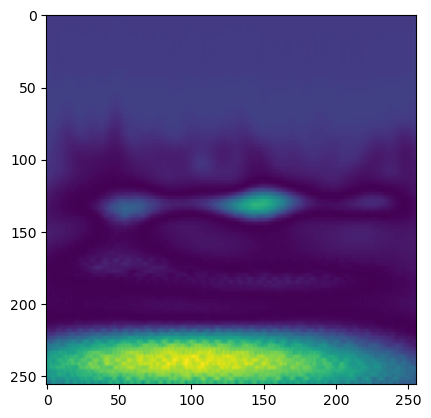

In [7]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
images, labels = next(iter(dataloader))
plt.imshow(images[0,0])

dataloader_average = DataLoader(average_dataset, batch_size=16, shuffle=True)
images, labels = next(iter(dataloader_average))
plt.imshow(images[0,0])

# Mock Model Training

In [7]:
class AlexNetMPSFinalOnly(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = self.model.classifier
        self.classifier[-1] = nn.Linear(in_features=4096, out_features=3)

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# model = AlexNetMPSFinalOnly().to(device)

In [8]:
class AlexNetMPSSuddenDescend(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = classifier_sudden

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# model = AlexNetMPSSuddenDescend().to(device)

In [10]:
class AlexNetMPSLongDescend(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = classifier_gradual_descend_long

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# model = AlexNetMPSLongDescend().to(device)

In [11]:
class AlexNetMPSDescend(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = classifier_descend

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# model = AlexNetMPSDescend().to(device)

Notes: 

alex last layer + freeze features works pretty well on the averaged data, lr 0.001.

Descend with feature freeze and 0.001 lr learns well on averaged data


I think the big scalogram is just way to big for the resolution of the model. I wonder how they did it in the paper?


In [54]:
import seaborn as sns
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    """Plots the confusion matrix as a heatmap."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

In [ ]:
def train_val_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="mps"):
    model.to(device)
    best_val_acc = 0.0

    ### storing lossess and accuracies
    epoch_loss_list, epoch_val_loss_list = [], []
    epoch_acc_list, epoch_val_acc_list = [], []

    ### store f1 metrics 
    epoch_f1_list, epoch_precision_list, epoch_recall_list, epoch_specificity_list = [], [], [], []
    epoch_val_f1_list, epoch_val_precision_list, epoch_val_recall_list, epoch_val_specificity_list = [], [], [], []

    ### epoch looping
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        all_preds, all_labels = [], [] # to compute metrics

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)  # Sum up batch loss
            _, predicted = outputs.max(1) # predicted class
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            ### storing predicitions
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        ### get accuracy
        epoch_loss = running_loss / len(train_loader.dataset)  # Normalize by dataset size
        epoch_acc = 100.0 * correct / total  # Ensure percentage scaling
        
        ### classification stats
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
        f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
        conf_mat = confusion_matrix(all_labels, all_preds)
        specificity = np.mean(conf_mat.diagonal()/ conf_mat.sum(axis=1)) if conf_mat.sum() != 0 else 0

        ### metric storage
        epoch_loss_list.append(epoch_loss)
        epoch_acc_list.append(epoch_acc)
        epoch_f1_list.append(f1)
        epoch_precision_list.append(precision)
        epoch_recall_list.append(recall)
        epoch_specificity_list.append(specificity)
        
        ### printing
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
        print(f" Train - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Specificity: {specificity:.4f}")


        ### Validation 
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        val_preds, val_labels = [], []

        with torch.no_grad():
            for val_images, val_targets in val_loader:
                val_images, val_targets = val_images.to(device), val_targets.to(device)
                val_outputs = model(val_images)
                val_loss += criterion(val_outputs, val_targets).item() * val_images.size(0)  # Accumulate batch loss

                _, val_predicted = val_outputs.max(1)
                val_total += val_targets.size(0)
                val_correct += val_predicted.eq(val_targets).sum().item()

                ### storing validation preds and labels
                val_preds.extend(val_predicted.cpu().numpy())
                val_labels.extend(val_targets.cpu().numpy())

        ### get metrics
        val_loss /= len(val_loader.dataset)  # Normalize by dataset size
        val_acc = 100.0 * val_correct / val_total  # Ensure percentage scaling

        val_precision = precision_score(val_labels, val_preds, average="weighted", zero_division=0)
        val_recall = recall_score(val_preds, val_labels, average="weighted", zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, average="weighted", zero_division=0)

        val_conf_mat = confusion_matrix(val_labels, val_preds)
        val_specificity = np.mean(val_conf_mat.diagonal() / val_conf_mat.sum(axis=1)) if val_conf_mat.sum() != 0 else 0

        ### store metrics
        epoch_val_loss_list.append(val_loss)
        epoch_val_acc_list.append(val_acc)
        epoch_val_f1_list.append(val_f1)
        epoch_val_precision_list.append(val_precision)
        epoch_val_recall_list.append(val_recall)
        epoch_val_specificity_list.append(val_specificity)

        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        print(f" Validation - Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, Specificity: {val_specificity:.4f}")

        # Track best validation accuracy
        best_val_acc = max(best_val_acc, val_acc)
    
    class_labels = np.unique(all_labels)  # Get class labels
    plot_confusion_matrix(conf_mat, class_labels, title="Training Confusion Matrix")
    plot_confusion_matrix(val_conf_mat, class_labels, title="Validation Confusion Matrix")

    # Plot Loss
    fig, ax = plt.subplots()
    ax.plot(epoch_loss_list, label="Train Loss")
    ax.plot(epoch_val_loss_list, label="Validation Loss")
    ax.set_title("Training and Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    fig.tight_layout()
    plt.show()

    # Plot Accuracy
    fig, ax = plt.subplots()
    ax.plot(epoch_acc_list, label="Train Accuracy")
    ax.plot(epoch_val_acc_list, label="Validation Accuracy")
    ax.set_title("Training vs. Validation Accuracy")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend()
    fig.tight_layout()
    plt.show()

    # Plot precision
    fig, ax = plt.subplots()
    ax.plot(epoch_precision_list, label="Train Precision")
    ax.plot(epoch_val_precision_list, label="Validation Precision")
    ax.set_title("Training vs. Validation Precision")
    ax.set_ylabel("Precision")
    ax.set_xlabel("Epoch")
    ax.legend()
    fig.tight_layout()
    plt.show()

    # Plot Recall
    fig, ax = plt.subplots()
    ax.plot(epoch_recall_list, label="Train Recall")
    ax.plot(epoch_val_recall_list, label="Validation Recall")
    ax.set_title("Training vs. Validation Recall")
    ax.set_ylabel("Recall")
    ax.set_xlabel("Epoch")
    ax.legend()
    fig.tight_layout()
    plt.show()

    # Plot Specificity
    fig, ax = plt.subplots()
    ax.plot(epoch_specificity_list, label="Train Specificity")
    ax.plot(epoch_val_specificity_list, label="Validation Specificity")
    ax.set_title("Training vs. Validation Specificity")
    ax.set_ylabel("Specificity")
    ax.set_xlabel("Epoch")
    ax.legend()
    fig.tight_layout()
    plt.show()

    print("Training complete.")
    return best_val_acc  # This should really return the model weights or something

In [135]:
def test_model(model, test_loader, criterion, device=None):
    model.eval()
    model.to(device)
    test_loss = 0.0
    correct = 0
    total = 0
    precision = 0
    f1_metric = 0
    recall = 0
    specificity = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets) # get the loss
            test_loss += loss.item() * inputs.size(0) # total loss

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / total

    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_metric = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_mat = confusion_matrix(all_labels, all_preds)
    specificity = np.mean(conf_mat.diagonal() / conf_mat.sum(axis=1)) if conf_mat.sum() != 0 else 0

    plot_confusion_matrix(cm=conf_mat, classes=np.unique(all_labels))

    return test_loss, accuracy, precision, recall, f1_metric, specificity

[ 36  50  17 187 137  80  55  82  79  99 202 307 116 310 223 220 230  92
 217 192 222 119 226  83 215 208 283  95  67  18 138 288 239 290 197  96
 318 133 207  64 210 251 291 149 311  71 276 204 268 201 124 224  35 234
  97 209  24 170 314 136  11  37  34 184 238 100  28 247 161 181 150 300
   4  47 235 107 323 229 287   6 148 188  59 211  31  51  73 134  21 152
  93 135  33  63 316 292 167  90 155  45 165 241 198 296 182   3 216 263
  30 242 194  27 193 303 154  12 205 246 162 256 261 299  88  61 312 125
 127  15  53 272 114  78  98 297  13 237 140 281 286 305 122 306  49 156
 144 273 147  43 252 317  75 121 143 218 106  84 277 159  74 164 231 111
 118 120 132 228 260 145 275 294 200 160 163 213  68 153  94 139  42 175
 195 301  89  56 110 270 102 214 203   7 130  91 285 219 244  46 109 115
  19 123  32 174 233   0 304 190 265 177 113  44 186 126 196  41 243  60
 248 289 141 278 225 131  77  66  39 129  16  54 266 185 320 258 157 255
 257 280  52 227 166 112 313  29 142 169   8  25 27

/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/1] - Loss: 2.2256, Accuracy: 29.89%
 Train - Precision: 0.2974, Recall: 0.2989, F1: 0.2960, Specificity: 0.2989
Validation - Loss: 1.1460, Accuracy: 33.33%
 Validation - Precision: 0.1111, Recall: 0.3333, F1: 0.1667, Specificity: 0.3333


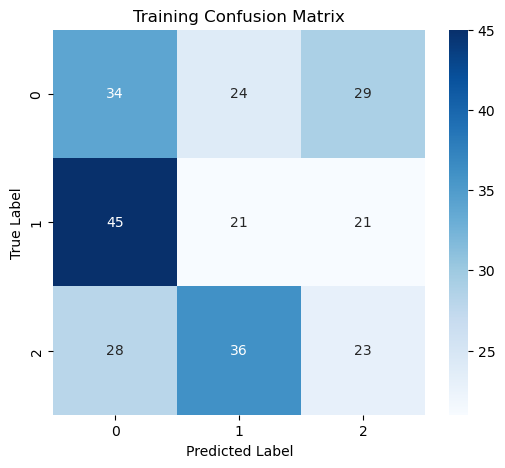

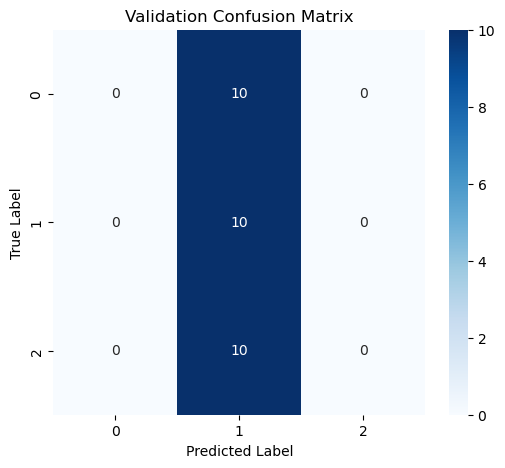

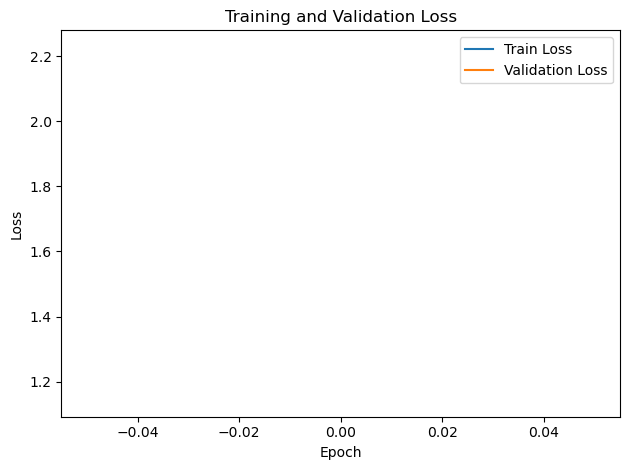

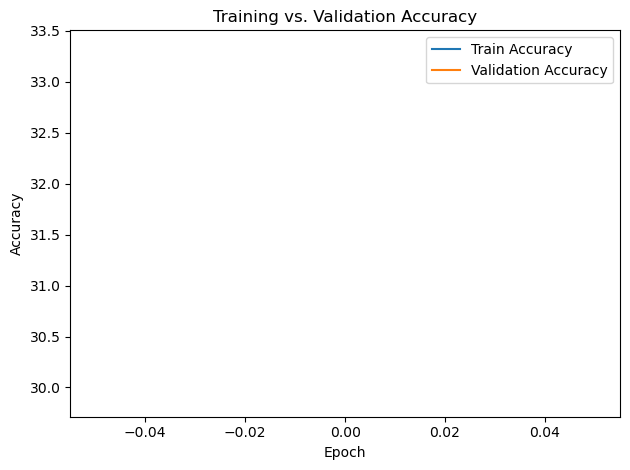

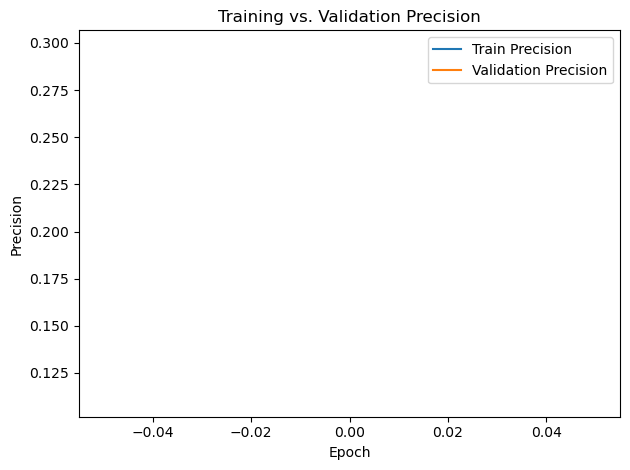

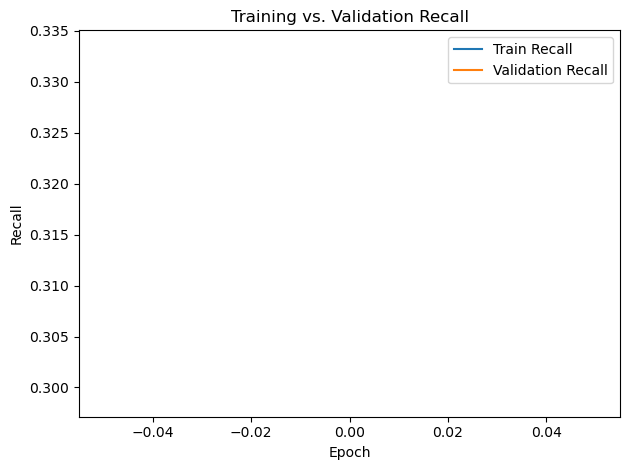

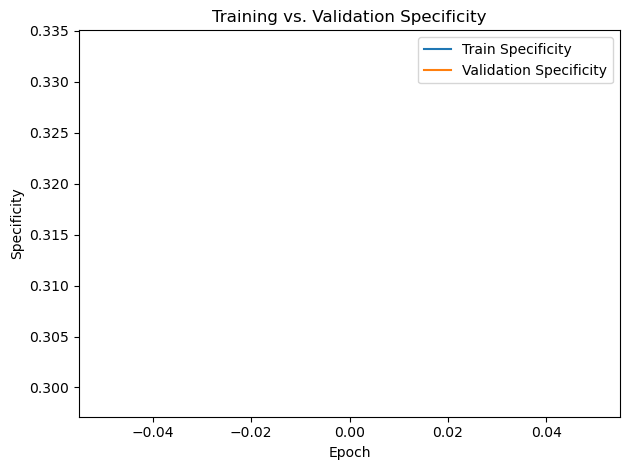

Training complete.


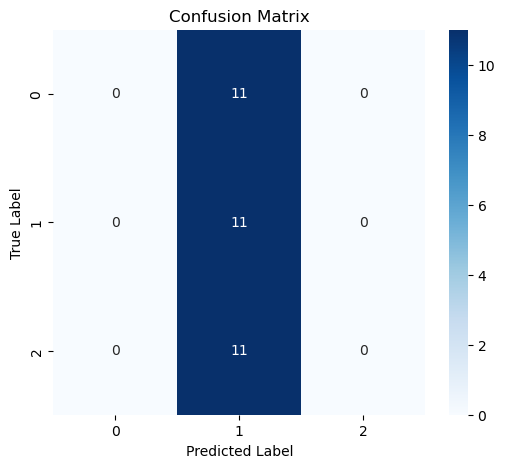

Test Loss: 1.1497796015305952 
Test Accuracy: 33.333333333333336 
Test Precision: 0.1111111111111111 
Test Recall: 0.3333333333333333 
Test F1: 0.16666666666666666 
Test Specificity: 0.3333333333333333
[ 35  50  18 187 144  92  66  94  91  98 193 309 136 310 220 214 229 103
 228 190 219 118 232  84 226 203 269 116  80  19 121 286 236 291 196  87
 319 146 205  78 212 263 293 151 316  72 274 202 267 211 127 221  27 224
  96 206  22 171 314 143   2  38  37 194 237 100  26 246 178 182 152 308
   5  47 225 108 323 223 285   6 150 188  58 216  39  51  73 147  12 154
 104 148  34  62 318 279 184 105 157  44 180 240 197 298 183   1 227 272
  32 249 199  25 192 301 156   3 204 245 162 248 259 307  89  69 312 128
 130  15  57 273 125  82  97 297  13 235 140 282 284 304 137 305  49 168
 159 275 149  36 241 317  75 120 158 207 107  85 276 166  74 165 230 111
 117 119 135 242 264 161 278 294 210 167 163 208  81 155 115 139  55 176
 200 287  90  56 110 268 102 213 198   7 133  95 270 209 239  45 109

/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/1] - Loss: 3.4888, Accuracy: 25.67%
 Train - Precision: 0.2548, Recall: 0.2567, F1: 0.2482, Specificity: 0.2567
Validation - Loss: 1.1047, Accuracy: 33.33%
 Validation - Precision: 0.1111, Recall: 0.3333, F1: 0.1667, Specificity: 0.3333


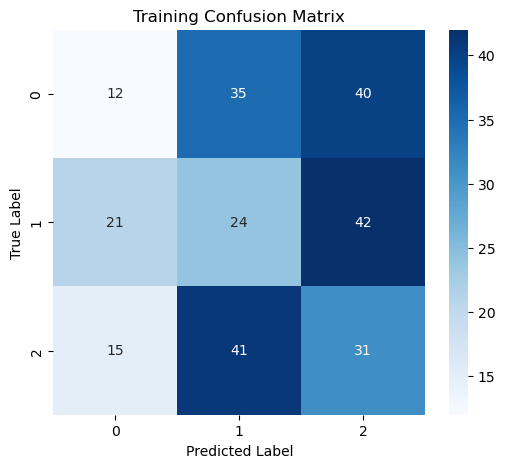

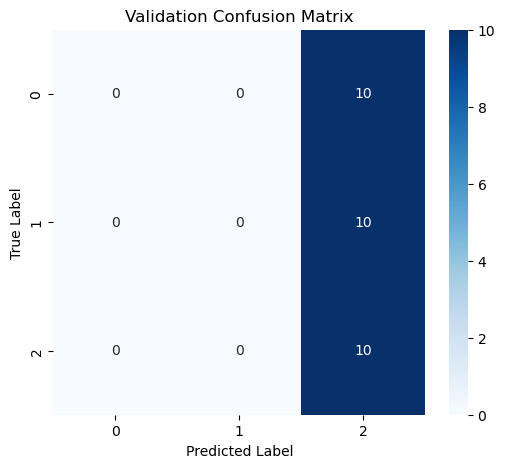

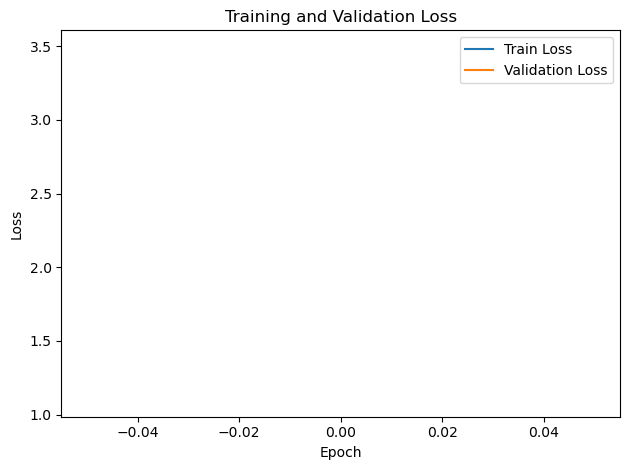

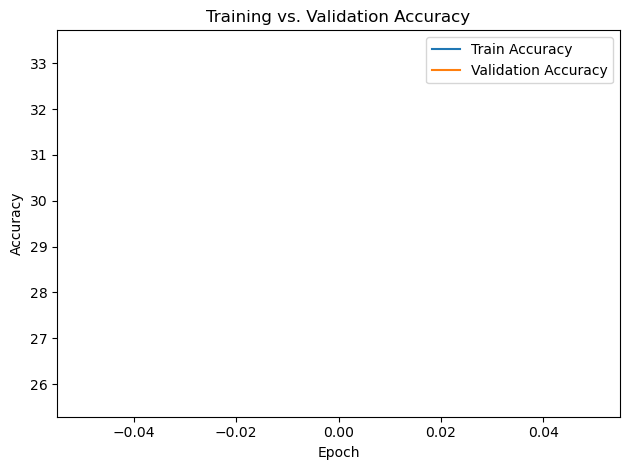

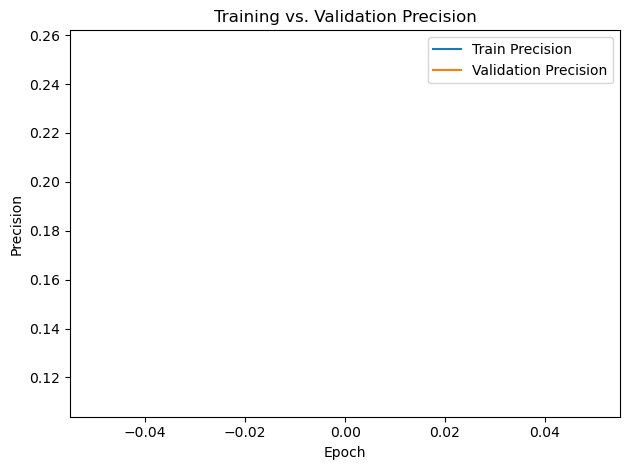

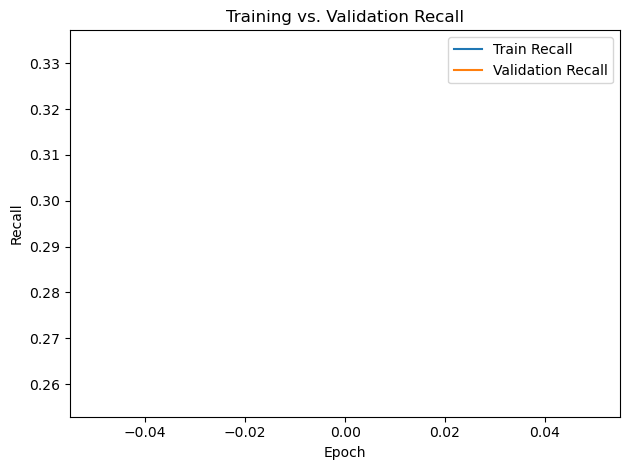

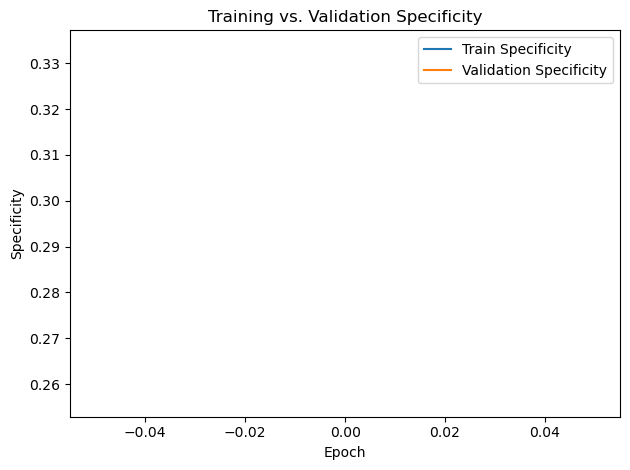

Training complete.


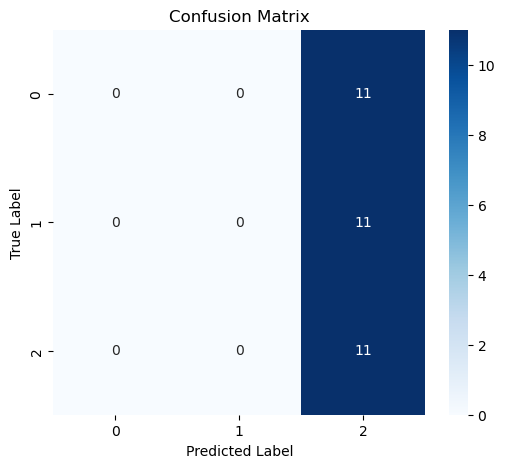

Test Loss: 1.1050917343659834 
Test Accuracy: 33.333333333333336 
Test Precision: 0.1111111111111111 
Test Recall: 0.3333333333333333 
Test F1: 0.16666666666666666 
Test Specificity: 0.3333333333333333
[ 28  48  16 186 142  81  54  91  80  99 202 307 122 297 220 214 229  94
 227 189 222 118 228  83 216 203 283 104  68  17 138 288 236 289 196  96
 318 146 206  57 210 253 290 151 311  72 261 204 269 201 125 224  27 234
  97 207  23 171 313 137   2  56  38 185 238 100  26 246 167 182 152 300
   4  45 235 109 323 223 287   5 150 188  59 211  30  52  73 147  12 154
  95 148  34  63 316 279 179 106 157  43 181 240 197 296 183   1 226 264
  29 243 195  25 190 303 156   3 205 245 163 256 258 299  90  69 310 126
 129   8  42 271 124  79  98 295  14 237 140 280 286 305 123 306  47 168
 158 272 149  35 241 317  75 120 145 209 108  85 274 161  74 180 230 112
 117 119 135 233 262 160 273 292 200 166 164 208  78 155 103 139  41 175
 199 301 105  58 111 270 102 213 198   6 133  93 284 219 239  44 110

/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/1] - Loss: 3.8046, Accuracy: 31.03%
 Train - Precision: 0.3083, Recall: 0.3103, F1: 0.3084, Specificity: 0.3103
Validation - Loss: 1.1678, Accuracy: 33.33%
 Validation - Precision: 0.1111, Recall: 0.3333, F1: 0.1667, Specificity: 0.3333


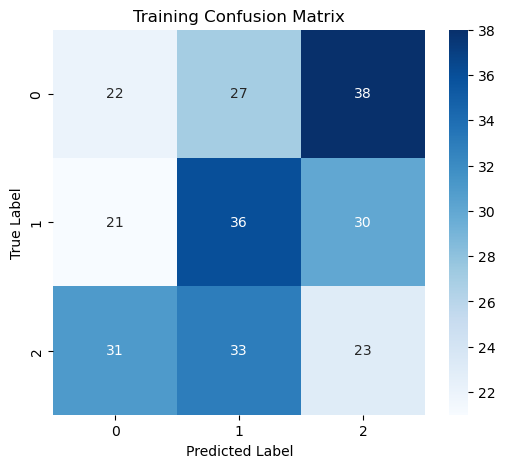

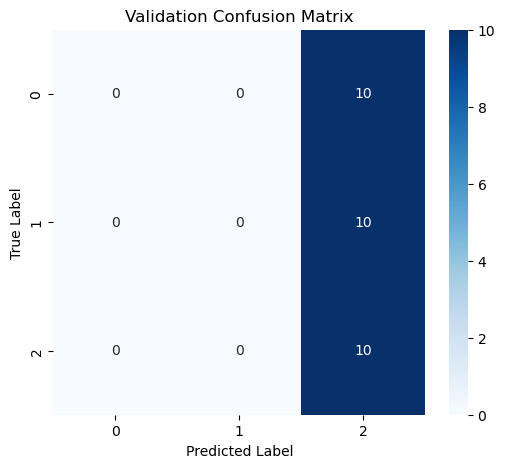

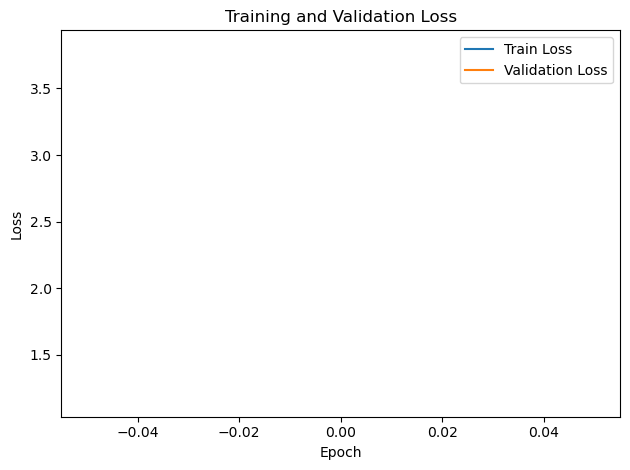

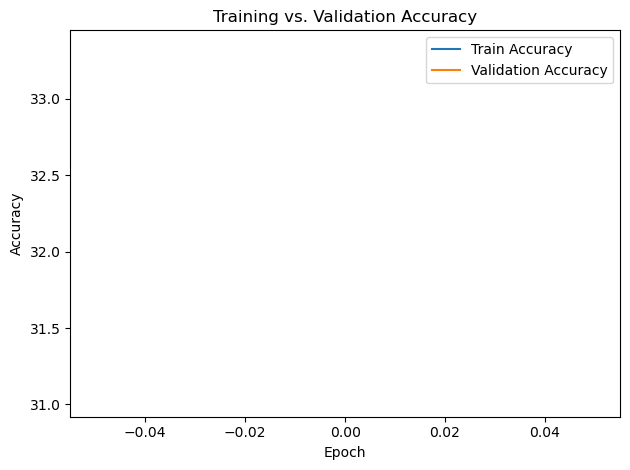

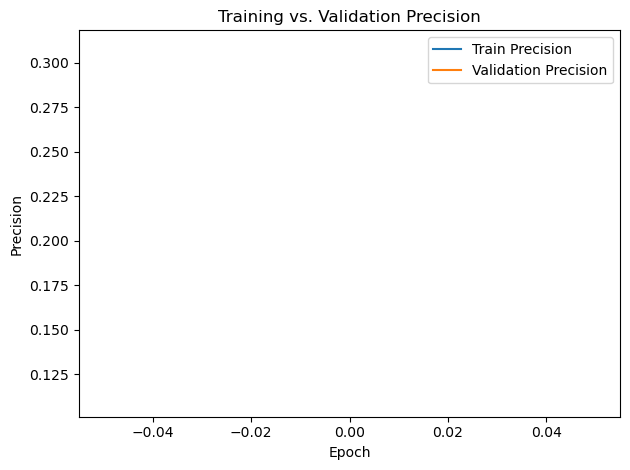

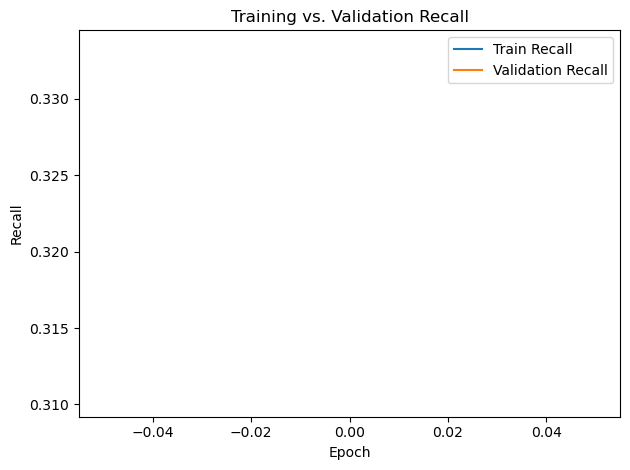

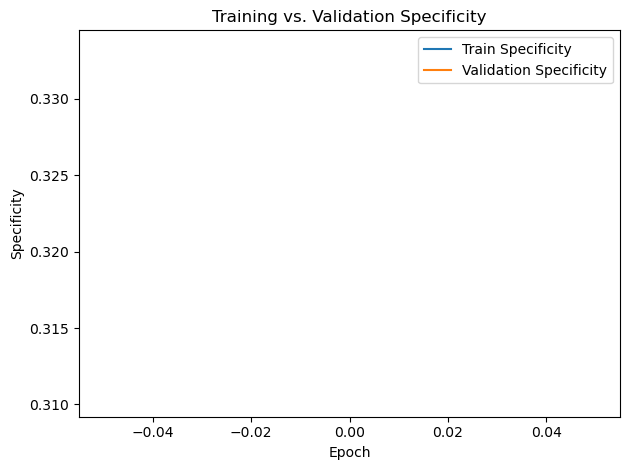

Training complete.


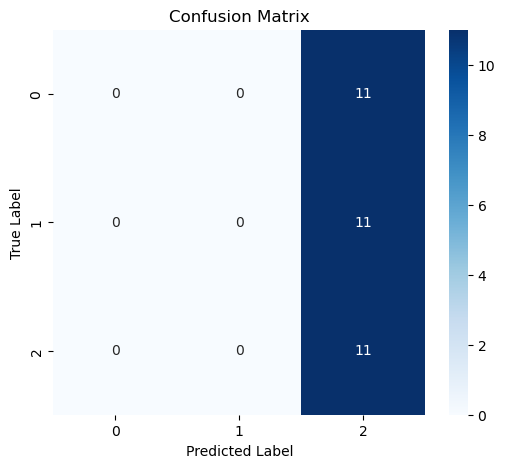

Test Loss: 1.1599297812490752 
Test Accuracy: 33.333333333333336 
Test Precision: 0.1111111111111111 
Test Recall: 0.3333333333333333 
Test F1: 0.16666666666666666 
Test Specificity: 0.3333333333333333
[ 27  49  16 177 137  81  57  91  80 100 192 308 116 297 223 220 230  93
 215 187 221 121 217  65 211 208 284 103  68  17 140 288 244 290 197  87
 319 132 204  66 200 251 291 147 316  70 261 193 270 199 114 222  26 225
  96 205  22 169 313 136   2  38  37 179 238 102  25 248 161 183 148 307
   4  44 234 107 323 229 287   5 146 191  58 201  31  50  71 133  12 150
  94 134  34  62 318 277 167  90 153  36 181 240 198 296 188   1 212 262
  30 233 185  24 189 303 152   3 202 247 164 257 258 300  85  60 310 124
 126   8  53 263 113  79  99 295  14 237 162 275 286 305 122 306  48 154
 145 264 135  28 241 315  74 139 144 206 106  83 274 159  72 180 236 110
 120 138 131 228 253 158 271 292 195 160 165 213  78 151  95 141  42 174
 194 301  89  56 109 283 119 214 203   6 129  92 285 218 245  43 108

/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/1] - Loss: 3.8448, Accuracy: 36.78%
 Train - Precision: 0.3709, Recall: 0.3678, F1: 0.3655, Specificity: 0.3678
Validation - Loss: 1.2136, Accuracy: 33.33%
 Validation - Precision: 0.1111, Recall: 0.3333, F1: 0.1667, Specificity: 0.3333


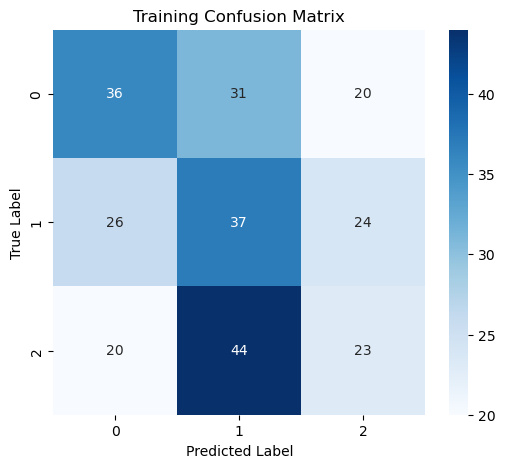

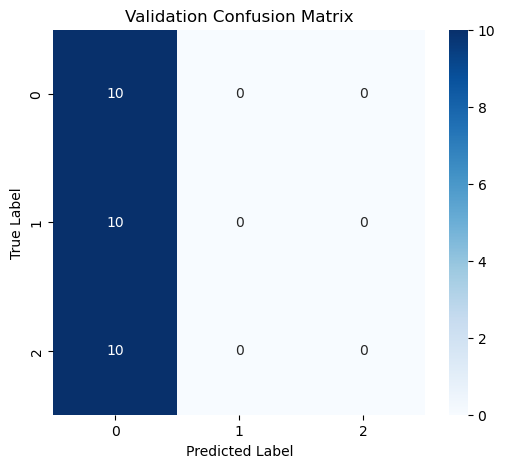

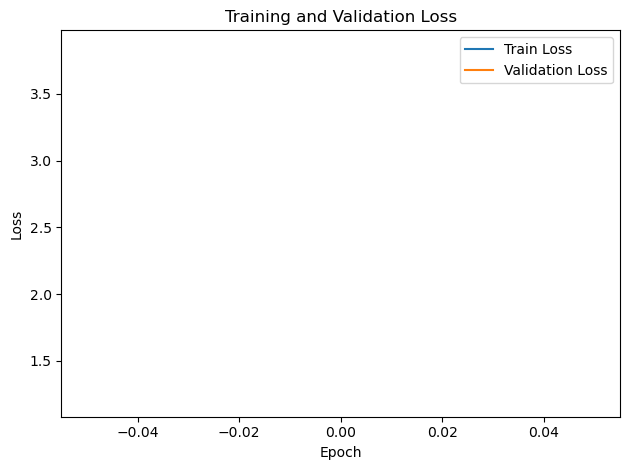

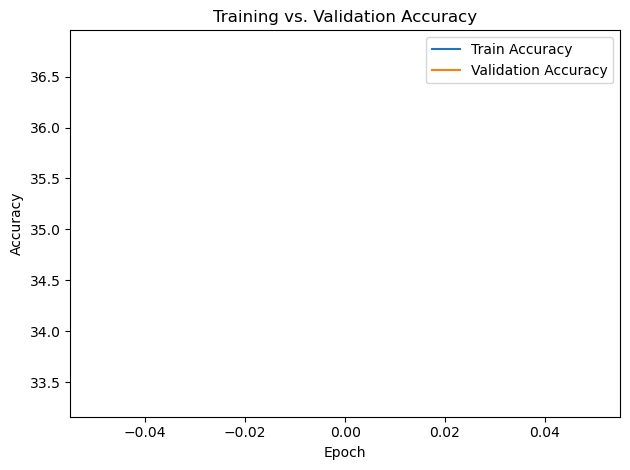

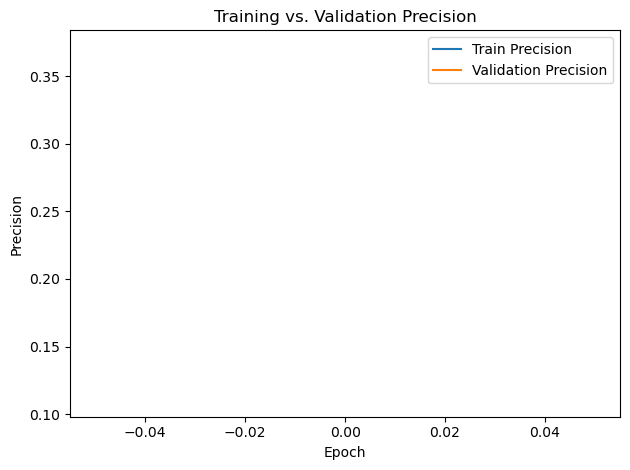

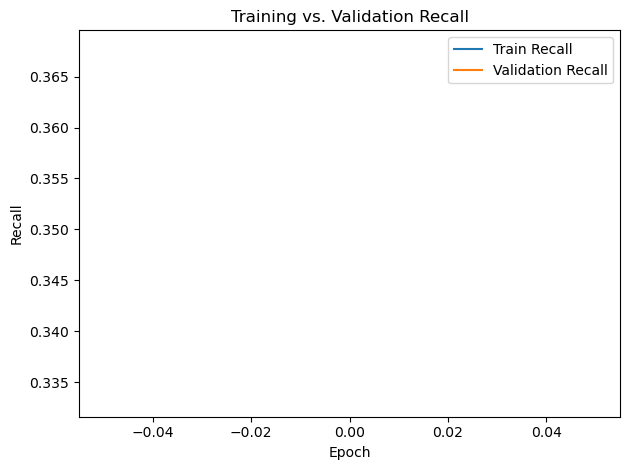

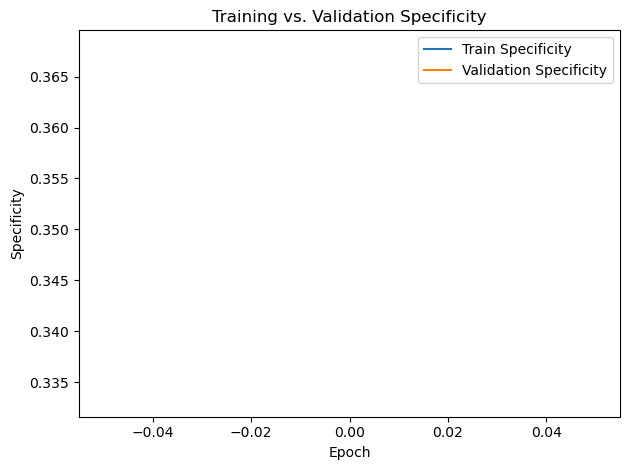

Training complete.


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import gc

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
data = dataset

X = np.array(data.data['FileName'])
y = np.array(data.data['Label'])

### We want an 80/10/10 Train Val Test Split
### But we also want a 10-Fold Cross Val

# First split into the 90/10 train/test

fold_counter = 0

outer_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 
for train_val_idx, test_idx in outer_folds.split(X, y):
    y_train_val = y[train_val_idx] # we do need this because we stratify based on the counts in the fold. 

    # then into 80/10 train/val
    train_index, val_index, _, _ = train_test_split( #this works because we don't care about the names, we just want the indexes to feed into the Subset class. Pytorch will take care of it later
        train_val_idx, # and labels share indexes with the data
        train_val_idx,
        test_size=0.1,
        stratify=y_train_val,
        random_state=42
    )

    assert(len(np.intersect1d(train_index, val_index)) == 0)
    assert(len(np.intersect1d(train_index, test_idx)) == 0)
    assert(len(np.intersect1d(val_index, test_idx)) == 0)

    train_subset = Subset(data, train_index.tolist())
    val_subset = Subset(data, val_index.tolist())

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)

    train_labels = [data.data.iloc[i, 1] for i in train_index]
    test_labels = [data.data.iloc[i, 1] for i in test_idx]

    # Compute class distributions
    unique_labels, train_counts = np.unique(np.array(train_labels), return_counts=True)
    _, test_counts = np.unique(np.array(test_labels), return_counts=True)

    print("Train label distribution:", dict(zip(unique_labels, train_counts)))
    print("Validation label distribution:", dict(zip(unique_labels, test_counts)))

    model = AlexNetMPSDescend().to(device=device)
    model.classifier.apply(lambda m: m.reset_parameters() if type(m) == nn.Linear else None) # make sure the parameters are reset between folds
    full_feature_freeze(model) # freeze the Conv Layers - or whatever else kind of freeze that you want. 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    val_acc = train_val_model(model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, num_epochs=1)
    
    test_subset = Subset(data, test_idx)
    test_loader = DataLoader(test_subset, batch_size=8, shuffle=False)
    test_loss, accuracy, precision, recall, f1_metric, specificity = test_model(model=model, test_loader=test_loader, criterion=criterion, device=device)
    print(f"Test Loss: {test_loss} \n"
          f"Test Accuracy: {accuracy} \n"
          f"Test Precision: {precision} \n"
          f"Test Recall: {recall} \n"
          f"Test F1: {f1_metric} \n"
          f"Test Specificity: {specificity}")
    fold_counter += 1



    # Flush the GPU of model weights
    del model
    del optimizer
    del criterion
    del train_loader
    del test_loader

    gc.collect()
    torch.mps.empty_cache()


# Grad Cam Stuff

In [ ]:
import cv2

# Add a batch dimension to the input tensor
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        self.model.zero_grad()
        target = output[0][target_class]
        target.backward()

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

Ok, so grad_cam works, and we know that the parameter freezing we need to do during a training run. So let's see if we can actually do a mini data pipeline here.

I don't think there is any way of getting around saving the scalograms as PNGs because otherwise you wouldn't get the RGB layers, but that is something to think about.

In any case, I have some saved, I think from one subject. Let's see what they look like again.

tensor([[ -3.0414, -21.5060, -20.4484]], device='mps:0')


/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torch/nn/modules/module.py:1805: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


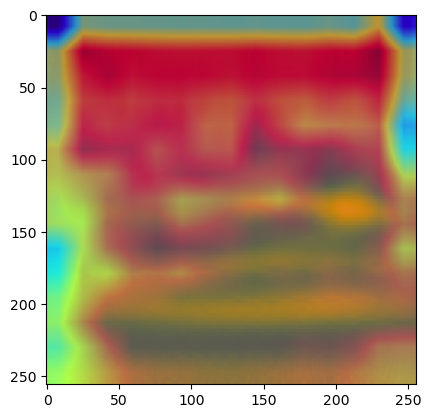

In [100]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average/a_average_channel_7.png")
input_tensor = preprocess(input_image)
# Add a batch dimension to the input tensor
input_batch = input_tensor.unsqueeze(dim=0).to(device)

# Ensure the model is in evaluation mode
trained_model.eval()

# Pass the input tensor through the model
with torch.no_grad():
    output = trained_model(input_batch)

print(output)

# Generate Grad-CAM
grad_cam = GradCAM(trained_model, trained_model.features[10])
target_class = output.argmax().item()
cam = grad_cam.generate_cam(input_batch, target_class)

# Convert input image to RGB and visualize the Grad-CAM over the original image
input_image_rgb = input_image.convert("RGB")
input_image_np = np.array(input_image_rgb.resize((input_tensor.shape[1], input_tensor.shape[2])))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(input_image_np) / 255
overlay = overlay / np.max(overlay)

plt.imshow(overlay)
plt.show()

tensor([[-14.3367,  -4.9464, -13.3994]], device='mps:0')


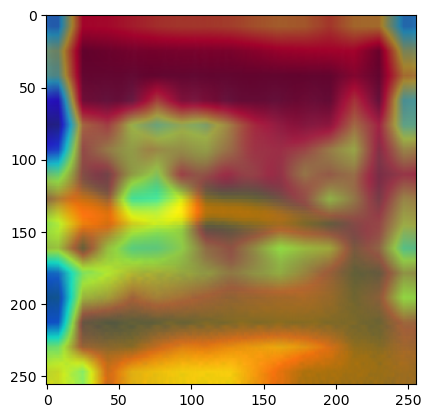

In [101]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average/e_average_channel_56.png")
input_tensor = preprocess(input_image)
# Add a batch dimension to the input tensor
input_batch = input_tensor.unsqueeze(dim=0).to(device)

# Ensure the model is in evaluation mode
trained_model.eval()

# Pass the input tensor through the model
with torch.no_grad():
    output = trained_model(input_batch)

print(output)

# Generate Grad-CAM
grad_cam = GradCAM(trained_model, trained_model.features[10])
target_class = output.argmax().item()
cam = grad_cam.generate_cam(input_batch, target_class)

# Convert input image to RGB and visualize the Grad-CAM over the original image
input_image_rgb = input_image.convert("RGB")
input_image_np = np.array(input_image_rgb.resize((input_tensor.shape[1], input_tensor.shape[2])))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(input_image_np) / 255
overlay = overlay / np.max(overlay)

plt.imshow(overlay)
plt.show()

tensor([[-18.9359, -23.0697,   0.0713]], device='mps:0')


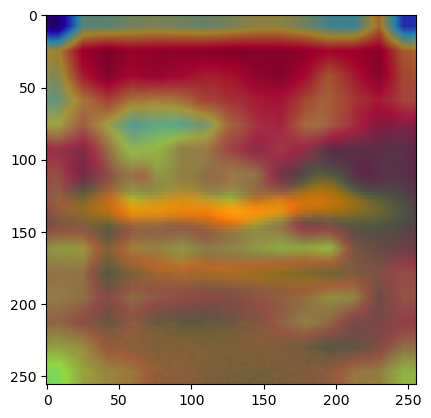

In [103]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average/i_average_channel_105.png")
input_tensor = preprocess(input_image)
# Add a batch dimension to the input tensor
input_batch = input_tensor.unsqueeze(dim=0).to(device)

# Ensure the model is in evaluation mode
trained_model.eval()

# Pass the input tensor through the model
with torch.no_grad():
    output = trained_model(input_batch)

print(output)

# Generate Grad-CAM
grad_cam = GradCAM(trained_model, trained_model.features[10])
target_class = output.argmax().item()
cam = grad_cam.generate_cam(input_batch, target_class)

# Convert input image to RGB and visualize the Grad-CAM over the original image
input_image_rgb = input_image.convert("RGB")
input_image_np = np.array(input_image_rgb.resize((input_tensor.shape[1], input_tensor.shape[2])))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(input_image_np) / 255
overlay = overlay / np.max(overlay)

plt.imshow(overlay)
plt.show()